In [1]:
import os 
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

external_data = Path('../data/external/')
processed_data = Path('../data/processed/')
raw_data = Path('../data/raw/')
interim_data = Path('../data/interim/')

**code postal avec données LaPoste**

In [304]:
poste = pd.read_csv(external_data/'laposte_hexasmal.csv',sep=';')
poste.loc[:,['latitude','longitude']] = poste['coordonnees_gps'].str.split(',',expand=True).values
poste = poste.rename(columns={'Code_commune_INSEE':'CODE_INSEE','Code_postal':'CODE_POSTAL'})
poste = poste.filter(['CODE_INSEE','CODE_POSTAL','latitude','longitude'])
poste['CODE_INSEE'] = ['0'+str(X) if len(str(X)) < 5 else X for X in poste['CODE_INSEE']]
poste

,CODE_INSEE,CODE_POSTAL,latitude,longitude
0,68336,68210,47.655039001,7.0935498603
1,68338,68230,48.0865424063,7.25076356699
2,68350,68420,48.0241428176,7.26224403842
3,68355,68640,47.5469824081,7.3170216886
4,68358,68230,47.9974106564,7.1537562966
...,...,...,...,...
39187,68322,68700,47.8218078225,7.13920916637
39188,68326,68780,47.6949071937,7.09088157788
39189,68327,68510,47.6236636155,7.41905540349
39190,68329,68140,48.0552314981,7.06088975747


In [306]:
poste.to_csv(f'{external_data}/data_gps.csv',index=False)

In [2]:
# Edite merge and mergev2
data = pd.read_csv(processed_data/'MERGE_data.csv')
data_clean = pd.read_csv(processed_data/'MERGE_data_clean.csv')


In [3]:
#load gps coordinates
## testing with data_gps.
data_gps = pd.read_csv(external_data/'data_gps.csv')

In [4]:
def plot_gps_column(data,column,ax,xlim=(-6.5, 10.5), ylim=(41.5, 51.5)):
    #data = pd.merge(dataframe_total,data_gps,on='CODE_INSEE')
    index = data[column].isna()
    if index.sum():
        ax.scatter(data.longitude[index], data.latitude[index], c='k', s=20)
        sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data[column][-index], s=20,cmap='Spectral')
    else:
        sc = ax.scatter(data.longitude, data.latitude, c=data[column], s=20,cmap='Spectral')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title("Column : {}, NaNs({})".format(column,index.sum()))
    fig.colorbar(sc,ax=ax)

# 1. Analyse du merge 

## Data avec NaNs 

In [5]:
indexes = ['CODE_INSEE', 'LIBCOM', 'DEP']
columns = list(data.drop(columns=indexes).columns)
print(columns)

['ACCES_SERVICE_PUBLIC', 'TX_NSCOL15P', 'TX_MENSEUL', 'TX_FAMMONO', 'TX_65ETPLUS', 'TX_25ETMOINS', 'COUVERTURE_MOBILE', 'TAUX_COUVERTURE_THD', 'TX_DEMANDEUR_EMPLOIS', 'TX_POVERTY', 'TX_RSA']


In [6]:
df = pd.merge(data,data_gps,on="CODE_INSEE")

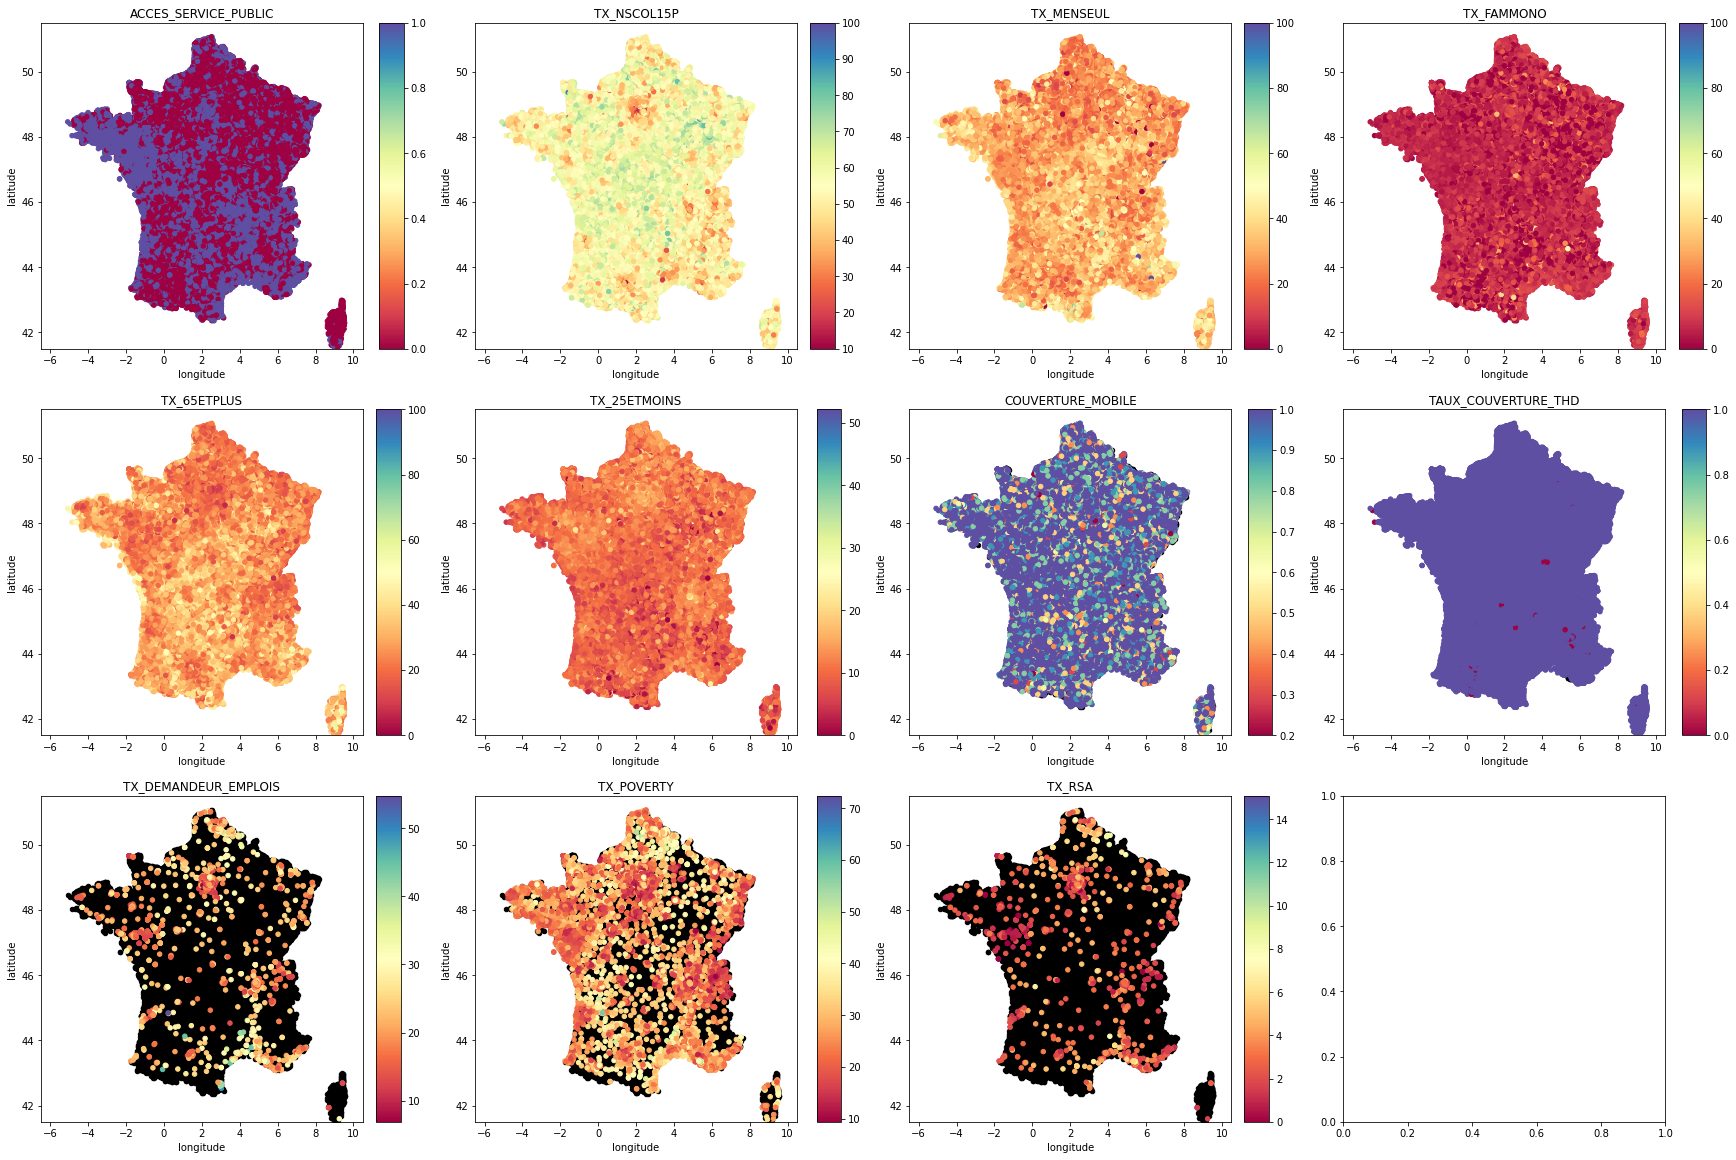

In [311]:
fig,axes = plt.subplots(3,len(columns)//3 +1,figsize=(24,16),constrained_layout=True)
ax = axes.ravel()
df = df
for i,col in enumerate(columns):    
    plot_gps_column(df,col,ax=ax[i])
    ax[i].set_title(col)

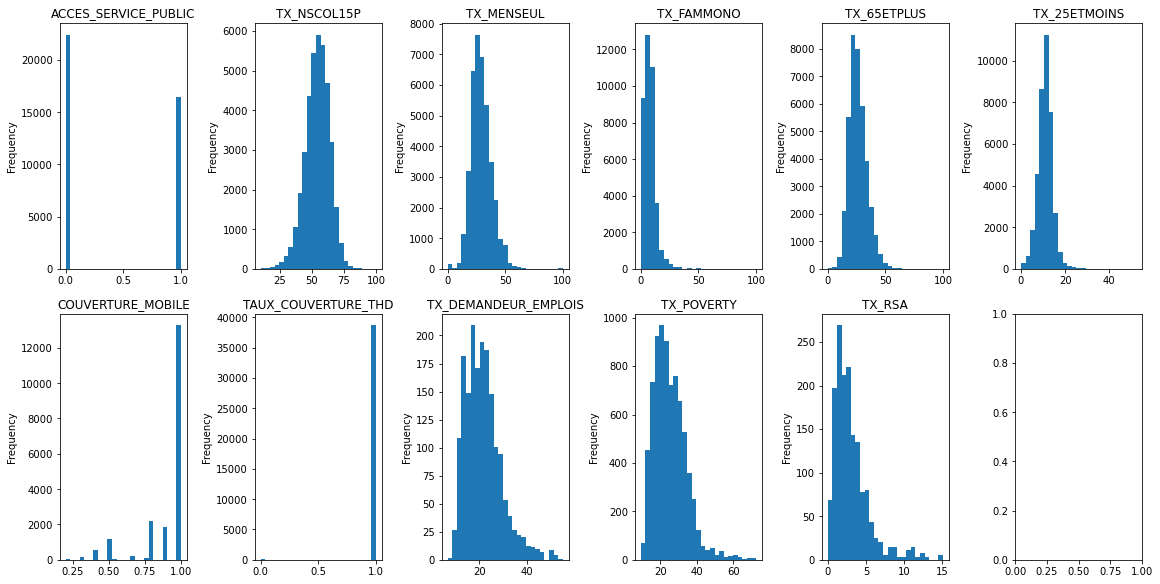

In [312]:
fig,axes = plt.subplots(2,len(columns)//2 +1,figsize=(16,8),constrained_layout=True)
ax = axes.ravel()
for i,col in enumerate(columns):    
    df[col].plot(kind='hist',bins=25,ax=ax[i])
    ax[i].set_title(col)


___________

## Data sans NaNs, moyenne par département

In [7]:
indexes = ['CODE_INSEE', 'LIBCOM', 'DEP']
columns = list(data_clean.drop(columns=indexes).columns)
print(columns)

['ACCES_SERVICE_PUBLIC', 'TX_NSCOL15P', 'TX_MENSEUL', 'TX_FAMMONO', 'TX_65ETPLUS', 'TX_25ETMOINS', 'COUVERTURE_MOBILE', 'TAUX_COUVERTURE_THD', 'TX_DEMANDEUR_EMPLOIS', 'TX_POVERTY', 'TX_RSA']


In [8]:
df_clean = pd.merge(data_clean,data_gps,on="CODE_INSEE")

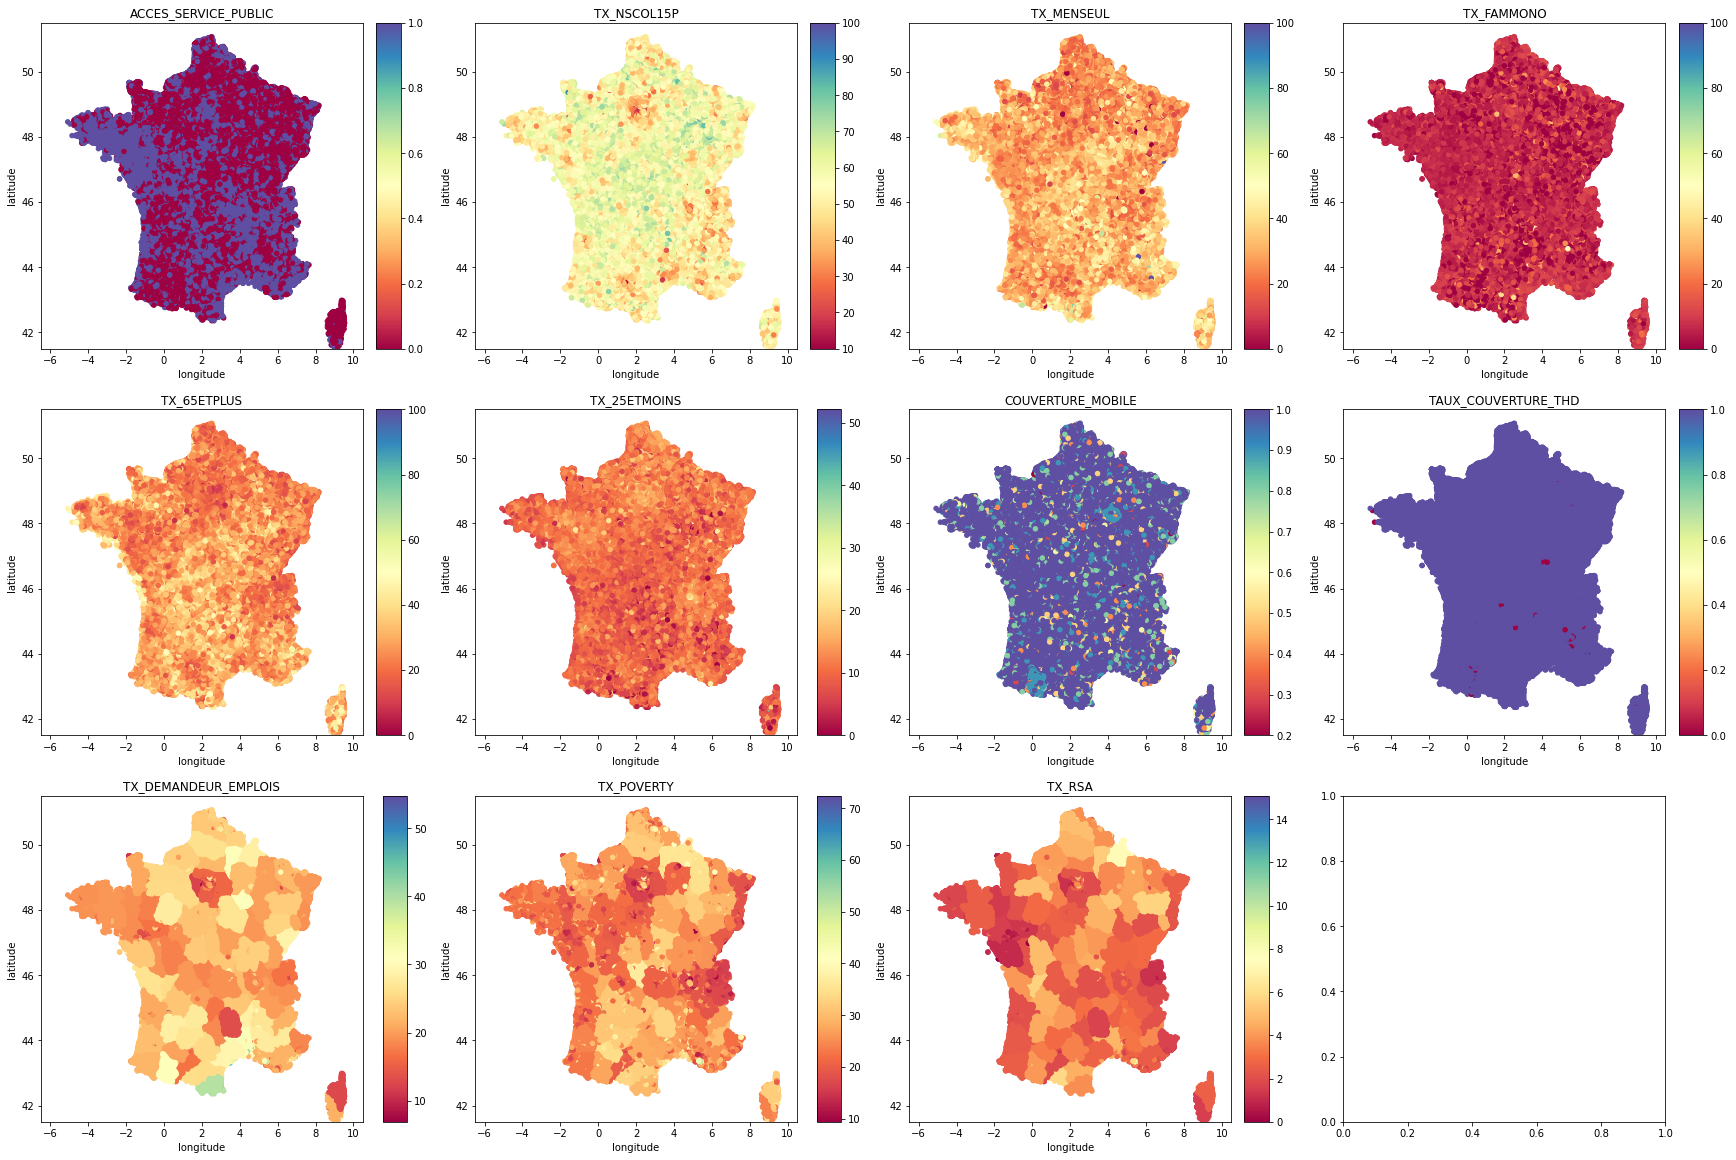

In [314]:
fig,axes = plt.subplots(3,len(columns)//3 +1,figsize=(24,16),constrained_layout=True)
ax = axes.ravel()
df = df_clean
for i,col in enumerate(columns):    
    plot_gps_column(df,col,ax=ax[i])
    ax[i].set_title(col)

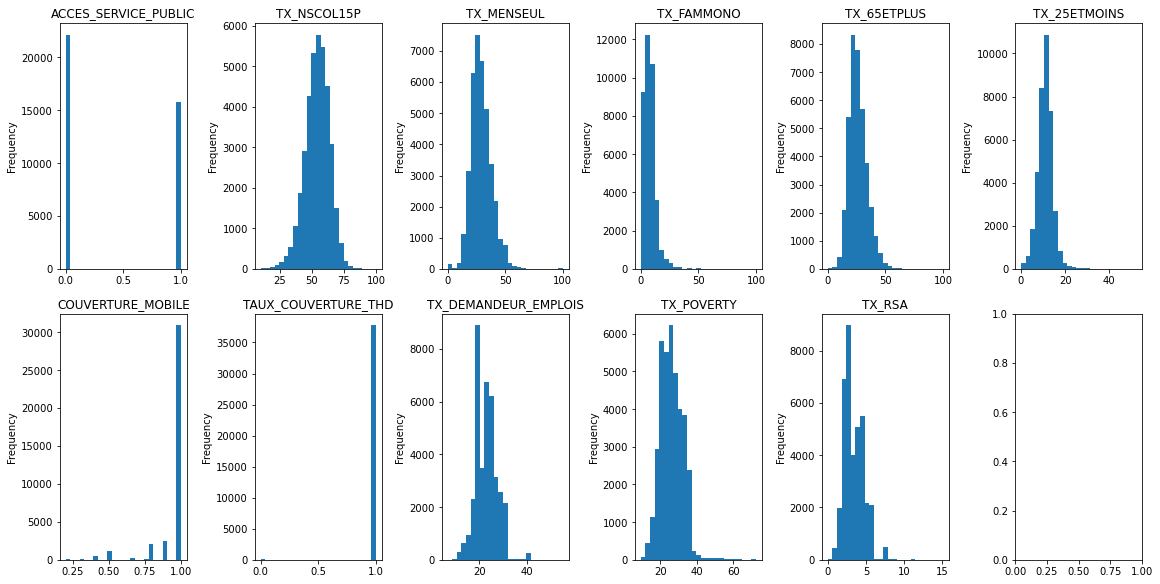

In [47]:
fig,axes = plt.subplots(2,len(columns)//2 +1,figsize=(16,8),constrained_layout=True)
ax = axes.ravel()
for i,col in enumerate(columns):    
    df[col].plot(kind='hist',bins=25,ax=ax[i])
    ax[i].set_title(col)


___________
# Contruire le score, exemple avec le département 31

Étape pour vérifier et faire le calcule du score

Nos données sont en pourcentage alors le facteur multiplicateur ira à la fin du calcule

In [9]:
BD = data_clean
BD.head()

,CODE_INSEE,LIBCOM,DEP,ACCES_SERVICE_PUBLIC,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_MOBILE,TAUX_COUVERTURE_THD,TX_DEMANDEUR_EMPLOIS,TX_POVERTY,TX_RSA
0,01001,L'Abergement-Clémenciat,01,0,52.154281,22.823614,4.831504,23.779236,11.309305,1.00,1.0,18.909985,19.558824,2.593516
1,01002,L'Abergement-de-Varey,01,0,40.425532,28.571429,4.761905,23.404255,7.978723,1.00,1.0,18.909985,19.558824,2.593516
2,01004,Ambérieu-en-Bugey,01,0,49.474587,41.515231,10.216084,20.733915,16.620013,1.00,1.0,21.754928,26.170897,2.593516
3,01005,Ambérieux-en-Dombes,01,1,53.574678,21.076206,6.601983,19.488442,13.854125,1.00,1.0,18.909985,19.558824,2.593516
4,01006,Ambléon,01,0,53.061224,36.363636,9.090909,26.530612,10.204082,0.65,1.0,18.909985,19.558824,2.593516


In [10]:
DEP='31'
BD.loc[BD['DEP'] == DEP,:]

,CODE_INSEE,LIBCOM,DEP,ACCES_SERVICE_PUBLIC,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_MOBILE,TAUX_COUVERTURE_THD,TX_DEMANDEUR_EMPLOIS,TX_POVERTY,TX_RSA
11279,31001,Agassac,31,0,55.555556,30.000000,20.000000,19.191919,14.141414,1.0,1.0,16.908706,19.889612,1.891551
11280,31002,Aignes,31,0,40.000000,30.000000,15.000000,31.219512,10.243902,0.4,1.0,16.908706,19.889612,1.891551
11281,31003,Aigrefeuille,31,0,19.243809,12.432113,6.130568,6.955533,18.359717,1.0,1.0,16.908706,19.889612,1.891551
11282,31004,Ayguesvives,31,1,32.660253,19.191667,9.551640,15.489045,12.572846,1.0,1.0,16.908706,13.693271,1.891551
11283,31005,Alan,31,0,54.958678,29.629630,11.111111,33.057851,8.264463,1.0,1.0,16.908706,19.889612,1.891551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11860,31589,Villenouvelle,31,1,41.253508,19.626168,7.476636,18.334892,11.412535,1.0,1.0,16.908706,19.889612,1.891551
11861,31590,Binos,31,0,61.290323,33.333333,0.000000,16.129032,12.903226,1.0,1.0,16.908706,19.889612,1.891551
11862,31591,Escoulis,31,0,54.666667,44.444444,0.000000,36.000000,8.000000,1.0,1.0,16.908706,19.889612,1.891551
11863,31592,Larra,31,0,38.285308,13.128935,7.816819,12.999808,12.939051,1.0,1.0,16.908706,19.889612,1.891551


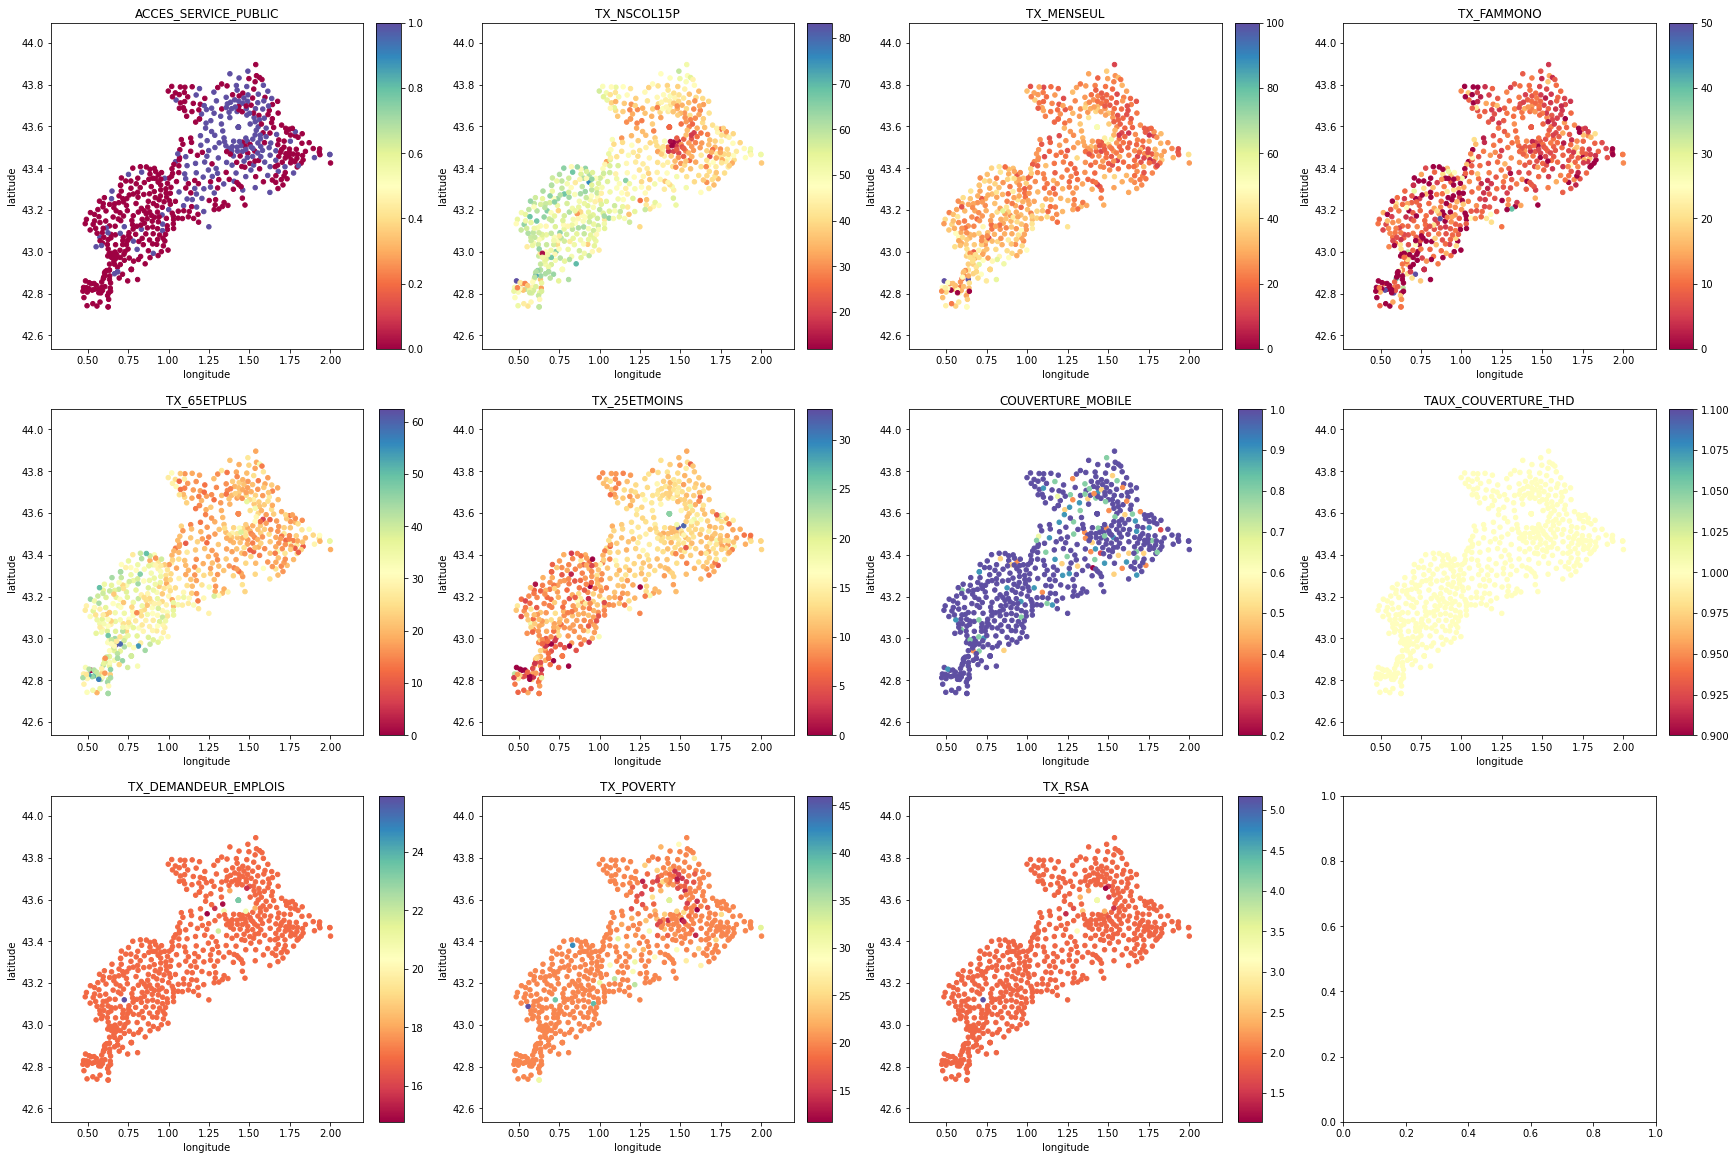

In [11]:
BD_gps = pd.merge(BD.loc[BD['DEP'] == DEP,:],data_gps,on='CODE_INSEE')
fig,axes = plt.subplots(3,len(columns)//3 +1,figsize=(24,16),constrained_layout=True)
ylim = (BD_gps.latitude.min()-0.2,BD_gps.latitude.max()+0.2)
xlim = (BD_gps.longitude.min()-0.2,BD_gps.longitude.max()+0.2)
ax = axes.ravel()

df = BD_gps
for i,col in enumerate(columns):    
    plot_gps_column(df,col,ax=ax[i],xlim=xlim,ylim=ylim)
    ax[i].set_title(col)

In [12]:
df

,CODE_INSEE,LIBCOM,DEP,ACCES_SERVICE_PUBLIC,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_MOBILE,TAUX_COUVERTURE_THD,TX_DEMANDEUR_EMPLOIS,TX_POVERTY,TX_RSA,CODE_POSTAL,latitude,longitude
0,31001,Agassac,31,0,55.555556,30.000000,20.000000,19.191919,14.141414,1.0,1.0,16.908706,19.889612,1.891551,31230,43.372095,0.885301
1,31002,Aignes,31,0,40.000000,30.000000,15.000000,31.219512,10.243902,0.4,1.0,16.908706,19.889612,1.891551,31550,43.334923,1.586458
2,31003,Aigrefeuille,31,0,19.243809,12.432113,6.130568,6.955533,18.359717,1.0,1.0,16.908706,19.889612,1.891551,31280,43.569364,1.584214
3,31004,Ayguesvives,31,1,32.660253,19.191667,9.551640,15.489045,12.572846,1.0,1.0,16.908706,13.693271,1.891551,31450,43.429024,1.594394
4,31005,Alan,31,0,54.958678,29.629630,11.111111,33.057851,8.264463,1.0,1.0,16.908706,19.889612,1.891551,31420,43.220088,0.927626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,31589,Villenouvelle,31,1,41.253508,19.626168,7.476636,18.334892,11.412535,1.0,1.0,16.908706,19.889612,1.891551,31290,43.437920,1.663035
596,31590,Binos,31,0,61.290323,33.333333,0.000000,16.129032,12.903226,1.0,1.0,16.908706,19.889612,1.891551,31440,42.904718,0.608458
597,31591,Escoulis,31,0,54.666667,44.444444,0.000000,36.000000,8.000000,1.0,1.0,16.908706,19.889612,1.891551,31260,43.111447,1.031328
598,31592,Larra,31,0,38.285308,13.128935,7.816819,12.999808,12.939051,1.0,1.0,16.908706,19.889612,1.891551,31330,43.734073,1.224273


In [13]:
df['ACCES_SERVICE_PUBLIC'].mean()

0.305

In [320]:
df['ACCES_SERVICE_PUBLIC'].median()

0.0

In [243]:
pd.concat([df[col].div(df[col].median()) for col in axe2],axis=1).loc[:2]

,TX_MENSEUL,TX_FAMMONO,ACCES_SERVICE_PUBLIC
0,1.112191,2.400000,NaN
1,1.112191,1.800000,NaN
2,0.460896,0.735668,NaN


In [244]:
pd.concat([df[col].div(df[col].mean()) for col in axe2],axis=1).loc[:2]

,TX_MENSEUL,TX_FAMMONO,ACCES_SERVICE_PUBLIC
0,1.060172,2.330659,0.0
1,1.060172,1.747994,0.0
2,0.439339,0.714413,0.0


# Calcule du score
On a 4 axes et score global
1. **Global accès :** Sum `axe1` at `axe2` 
2. **Global competences :** Sum `axe3` at `axe4` 
3. **Score global :** sum `global acces` et `global competences`

### Définition d'axes

In [17]:
#1. Accès aux interfaces numériques
axe1 = ['TX_POVERTY','TAUX_COUVERTURE_THD','COUVERTURE_MOBILE']
#2. Accès à l'information
axe2 = ['TX_MENSEUL','TX_FAMMONO','ACCES_SERVICE_PUBLIC']
#3. Compétences administratives
axe3 = ['TX_25ETMOINS','TX_RSA','TX_DEMANDEUR_EMPLOIS']
#4. Compétences usages numériques
axe4 = ['TX_65ETPLUS','TX_NSCOL15P']
labels = ['ACCESS_INTERFACES_NUM','ACCESS_INFORMATION','COMPETENCES_ADMIN','COMPETENCES_USAGES']


In [40]:
df

,CODE_INSEE,LIBCOM,DEP,ACCES_SERVICE_PUBLIC,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_MOBILE,TAUX_COUVERTURE_THD,TX_DEMANDEUR_EMPLOIS,TX_POVERTY,TX_RSA,CODE_POSTAL,latitude,longitude
0,31001,Agassac,31,0,55.555556,30.000000,20.000000,19.191919,14.141414,1.0,1.0,16.908706,19.889612,1.891551,31230,43.372095,0.885301
1,31002,Aignes,31,0,40.000000,30.000000,15.000000,31.219512,10.243902,0.4,1.0,16.908706,19.889612,1.891551,31550,43.334923,1.586458
2,31003,Aigrefeuille,31,0,19.243809,12.432113,6.130568,6.955533,18.359717,1.0,1.0,16.908706,19.889612,1.891551,31280,43.569364,1.584214
3,31004,Ayguesvives,31,1,32.660253,19.191667,9.551640,15.489045,12.572846,1.0,1.0,16.908706,13.693271,1.891551,31450,43.429024,1.594394
4,31005,Alan,31,0,54.958678,29.629630,11.111111,33.057851,8.264463,1.0,1.0,16.908706,19.889612,1.891551,31420,43.220088,0.927626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,31589,Villenouvelle,31,1,41.253508,19.626168,7.476636,18.334892,11.412535,1.0,1.0,16.908706,19.889612,1.891551,31290,43.437920,1.663035
596,31590,Binos,31,0,61.290323,33.333333,0.000000,16.129032,12.903226,1.0,1.0,16.908706,19.889612,1.891551,31440,42.904718,0.608458
597,31591,Escoulis,31,0,54.666667,44.444444,0.000000,36.000000,8.000000,1.0,1.0,16.908706,19.889612,1.891551,31260,43.111447,1.031328
598,31592,Larra,31,0,38.285308,13.128935,7.816819,12.999808,12.939051,1.0,1.0,16.908706,19.889612,1.891551,31330,43.734073,1.224273


In [79]:
def score_axis(df,axe):    
    #points = pd.concat([df.groupby('DEP')[col].transform(lambda x : x / x.mean()) for col in axe],axis=1) #tx in '%', commune/mean_departement
    points = pd.concat([df[col].transform(lambda x : x / x.mean()) for col in axe],axis=1) #tx in '%', commune/mean_reference(dep, region, nation)
    return points.sum(axis=1).div(len(axe)) * 100 #sum variables in the axis and multiply by 100

### Obtention des points

In [83]:
# df has only data from 1 departement
score = pd.concat([score_axis(df,axe) for axe in[axe1,axe2,axe3,axe4]],axis=1) #calcule l'axis
score.columns = labels

# ----global score ! il faut diviser par le nombre de variables impliqués (change en dependant de selection d'utilisateur) 
score['GLOBAL_ACCES'] = (score['ACCESS_INTERFACES_NUM'] / len(axe1)) + (score['ACCESS_INFORMATION'] / len(axe2))
score['GLOBAL_COMPETENCES'] = (score['COMPETENCES_ADMIN'] / len(axe3)) + (score['COMPETENCES_USAGES']/ len(axe4))
score['SCORE GLOBAL'] = score['GLOBAL_ACCES'] + score['GLOBAL_COMPETENCES']
score.head()

,ACCESS_INTERFACES_NUM,ACCESS_INFORMATION,COMPETENCES_ADMIN,COMPETENCES_USAGES,GLOBAL_ACCES,GLOBAL_COMPETENCES,SCORE GLOBAL
0,100.946757,113.185199,111.127461,97.103396,71.377319,85.594185,156.971504
1,79.927314,93.719729,98.721506,103.224248,57.882348,84.519292,142.401640
2,100.946757,38.504992,124.554510,34.224454,46.483916,58.630397,105.114314
3,90.796579,169.072162,106.134640,65.137545,86.622914,67.946986,154.569899
4,100.946757,78.143828,92.420860,122.997143,59.696862,92.305525,152.002387


### Traduction dans quintiles

In [84]:
quintiles = pd.concat([pd.cut(score[col], bins=5,duplicates='drop',labels=range(1,6)) for col in score.columns],axis=1) #discretize values in five groups by columns
quintiles = pd.concat([BD_gps[indexes],quintiles],axis=1) #add info code_insee
quintiles.head()

,CODE_INSEE,LIBCOM,DEP,ACCESS_INTERFACES_NUM,ACCESS_INFORMATION,COMPETENCES_ADMIN,COMPETENCES_USAGES,GLOBAL_ACCES,GLOBAL_COMPETENCES,SCORE GLOBAL
0,31001,Agassac,31,3,3,2,3,3,3,3
1,31002,Aignes,31,1,2,2,3,2,3,2
2,31003,Aigrefeuille,31,3,1,3,1,1,2,1
3,31004,Ayguesvives,31,2,4,2,2,4,2,3
4,31005,Alan,31,3,2,2,3,2,4,2


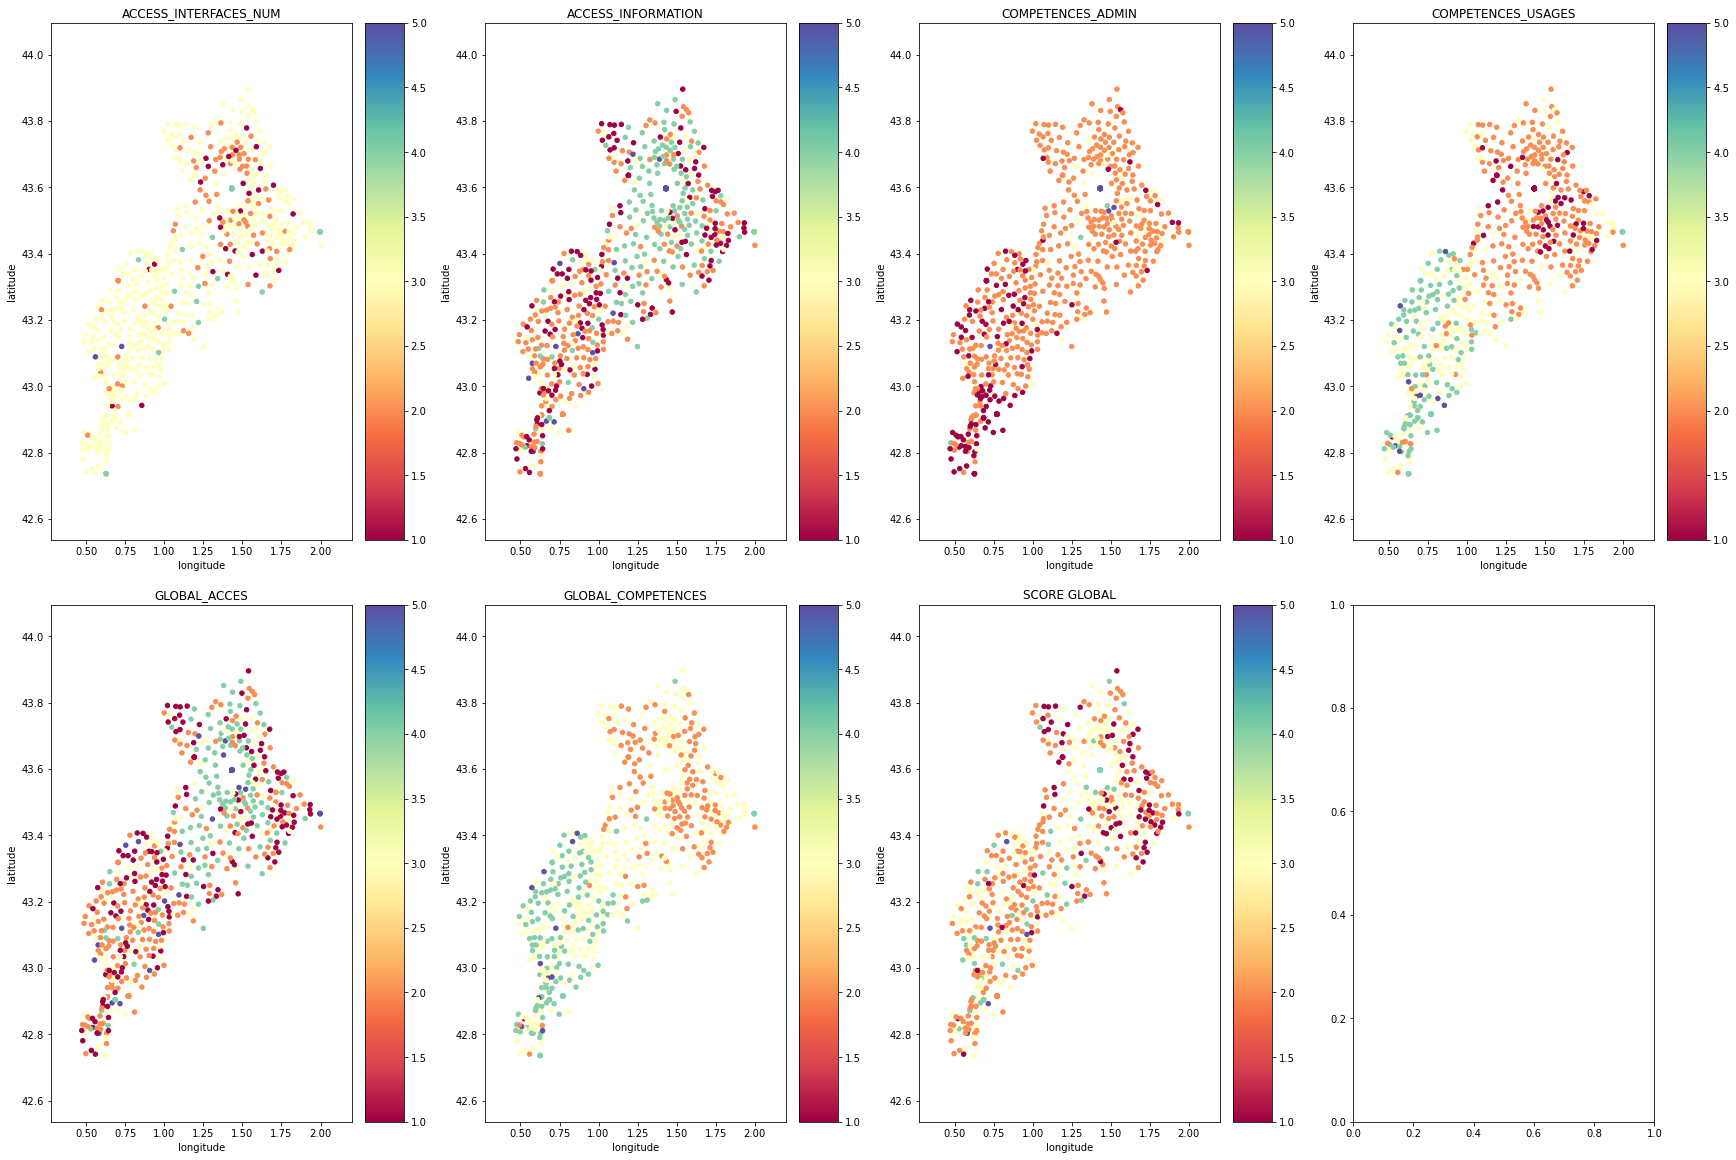

In [82]:
df2 = pd.merge(quintiles,data_gps,on='CODE_INSEE') #merge with gps
ylim = (df2.latitude.min()-0.2,df2.latitude.max()+0.2)
xlim = (df2.longitude.min()-0.2,df2.longitude.max()+0.2)
colums = score.columns
fig,axes = plt.subplots(2,len(colums)//2+1,figsize=(24,16),constrained_layout=True)
ax = axes.ravel()
for i,col in enumerate(colums):    
    plot_gps_column(df2,col,ax=ax[i],xlim=xlim,ylim=ylim)
    ax[i].set_title(col)